### Rate map for individual session

#### Input files
From my data:
* .clu: spike cluster IDs
* .res: spike timestamps
* .des: cluster cell types (filter for PYRs)
* .des_full: (optional) cluster brain region
* .reward_arms: baited arms

From Vlad's preprocessing script output:
* .lwhl_vladVersion: linearized positions per whl frame and arm ID
    - fixed_1d_pos
    - fixed_arm_id
* .speed_vladVersion: animal speed
* .trials_vladVersion: trial start and end times

#### Parameters
length_arm = 160
sampling_rate_whl = 39.0625
sampling_rate_res = 20000
speed_threshold = 5

#### To do:
* fix gaps in rate map
* exclude bad cells and apply speed filter
* combine sessions in day, show both individually

In [255]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

In [256]:
animal = 'JC315'
day = 20240330
session = 'training1'
arm = 3 # honey; 4 in my numbering

In [257]:
path = f"/Users/andrea/adata_laptop/Merged/{animal}-{day}/" # path to my data
preprocessed_path = f"/Users/andrea/github/vlad_analysis_folder/{animal}-{day}/" # path to Vlad's preprocessed files

# Parameters
length_arm = 160

sampling_rate_whl = 39.0625
sampling_rate_res = 20000
sr_conversion = sampling_rate_res/sampling_rate_whl # sampling rate ratio
speed_threshold = 5

In [258]:
# Import my data
res = np.fromfile(f"{path}{animal}-{day}_{session}.res",dtype=int,sep=" ")
clu_import = np.fromfile(f"{path}{animal}-{day}_{session}.clu",dtype=int, sep=" ")
clu = clu_import[1:] # first cluster is total number of clusters
des_import = np.loadtxt(f"{path}{animal}-{day}.des",dtype=str)
des = np.concatenate([['noise', 'mua'], des_import]) # pad first two clusters to match clu numbering
des_full = np.loadtxt(f"{path}{animal}-{day}.des_full",dtype=str)
reward_arms = np.fromfile(f"{path}{animal}-{day}_{session}.reward_arms",dtype=int,sep=" ")

# Open Vlad's preprocessed data
whl = pd.read_csv(f"{preprocessed_path}{animal}_{day}_{session}.lwhl_vladVersion", sep=' ')
speed = np.fromfile(f"{preprocessed_path}{animal}_{day}_{session}.speed_vladVersion", dtype=float, sep=' ')
trials = np.loadtxt(f"{preprocessed_path}{animal}_{day}_{session}.trials_vladVersion", dtype=int)

# Unpack whl
x1, y1 = whl.x1.to_numpy(), whl.y1.to_numpy()
linearized_pos_old = whl.linearized_pos_old.to_numpy()
arm_id_old = whl.arm_ID_old.to_numpy()
fixed_1d_pos = whl.fixed_1d_pos.to_numpy()
fixed_arm_id = whl.fixed_arm_id.to_numpy()
trial_id = whl.trial_id.to_numpy() # trial ID for each frame

In [259]:
# Filter for trials on selected arm
trial_subset = [
    (int(start), int(end)) for start, end in trials
    if fixed_arm_id[start] == arm
] # returns start and end frames for selected trials (whl sr)

print(f"{len(trial_subset)} trials in arm {arm}")

3 trials in arm 3


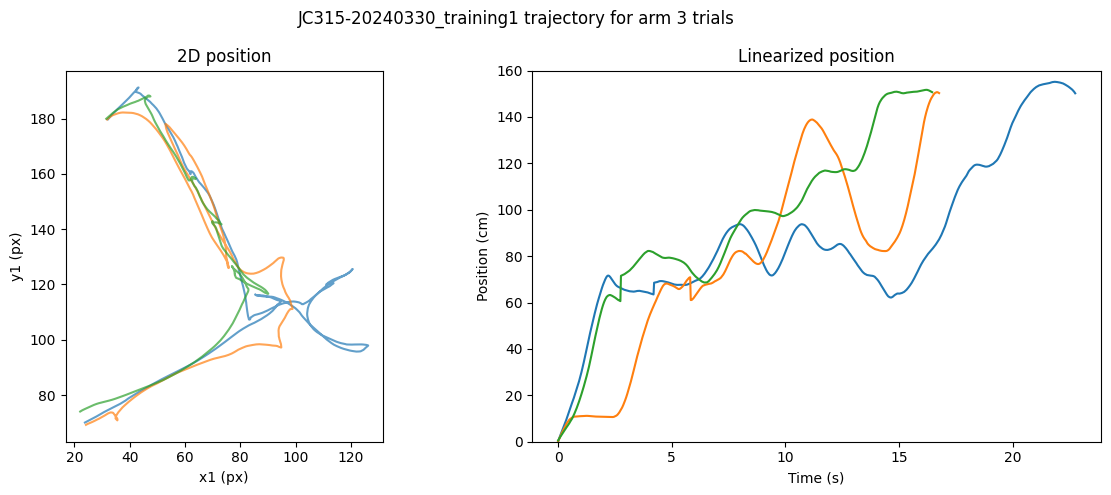

In [260]:
# Plot trajectory for trial subset

plt.figure(figsize=(12,5))
plt.suptitle(f"{animal}-{day}_{session} trajectory for arm {arm} trials")

plt.subplot(1,2,1)
for start_frame, end_frame in trial_subset:
    plt.plot(x1[start_frame:end_frame], y1[start_frame:end_frame], alpha=0.7)

plt.gca().set_aspect('equal')
plt.title("2D position")
plt.xlabel('x1 (px)'); plt.ylabel('y1 (px)')

plt.subplot(1,2,2)
for start_frame, end_frame in trial_subset:
    plt.plot(np.arange(end_frame-start_frame) / sampling_rate_whl,
             fixed_1d_pos[start_frame:end_frame])
plt.ylim(0, length_arm); plt.ylabel('Position (cm)')
plt.title("Linearized position")
plt.xlabel('Time (s)')
plt.tight_layout(); plt.show()


In [261]:
print(np.max(fixed_1d_pos))

155.16971690665736


[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 71 72 73 74 75
 76]


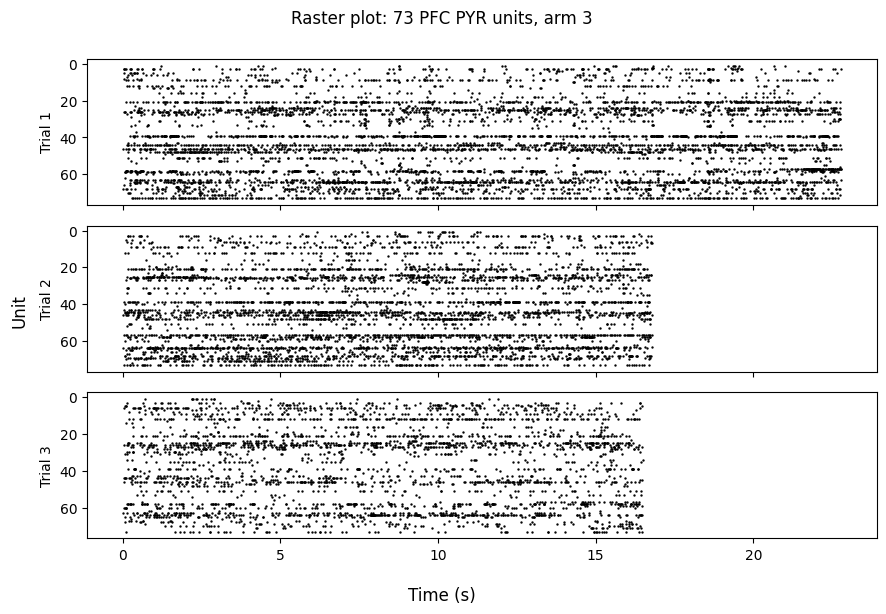

In [262]:
# Isolate PFC PYRs
pp_mask = des == "pp" # identify pp clusters from des file
pp_idx = np.where(pp_mask)[0] # return pp cluster IDs
spike_mask_pp = pp_mask[clu] # identify pp spikes; bool mask for each timestamp
res_pp = res[spike_mask_pp] # return pp timestamps
clu_pp = clu[spike_mask_pp] # return corresponding pp clusters

print(pp_idx)

clu_id_to_row = {row_id: i+1 for i, row_id in enumerate(pp_idx)} # renumber clusters from 1 to n
n_clusters = len(pp_idx)

# Raster plots for trial subset
fig, axs = plt.subplots(len(trial_subset), 1, figsize=(9, 2*len(trial_subset)), sharex=True, sharey=True)

for trial_idx, (start_frame, end_frame) in enumerate(trial_subset):
    # select spikes that fall within trial
    # convert whl frame indices to res timestamp indices:
    start_res = int(start_frame*sr_conversion)
    end_res = int(end_frame*sr_conversion)
    # select all spikes
    mask = (res_pp >= start_res) & (res_pp <= end_res)
    # select pp spikes
    trial_res = res_pp[mask] - start_res # convert to time since trial start
    trial_clu = clu_pp[mask] # corresponding clusters 
    # convert to seconds
    trial_sec = trial_res/sampling_rate_res
    # renumber timestamps with new cluster idx
    trial_clu_renumbered = [clu_id_to_row[c] for c in trial_clu]
    # plot each spike at the corresponding timestamp
    axs[trial_idx].scatter(trial_sec, trial_clu_renumbered, s=0.5, c="k")
    axs[trial_idx].set_ylabel(f"Trial {trial_idx+1}")
    axs[trial_idx].invert_yaxis() # so 0 is on the top

fig.supylabel("Unit")
fig.supxlabel("Time (s)")
fig.suptitle(f'Raster plot: {n_clusters} PFC PYR units, arm {arm}', y=1.001)
plt.tight_layout(); plt.show()

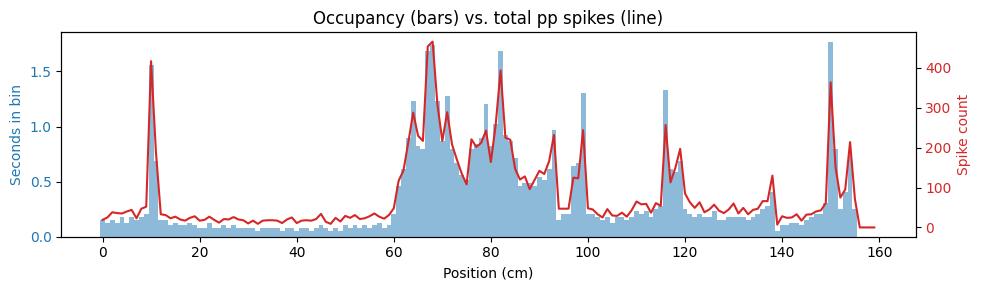

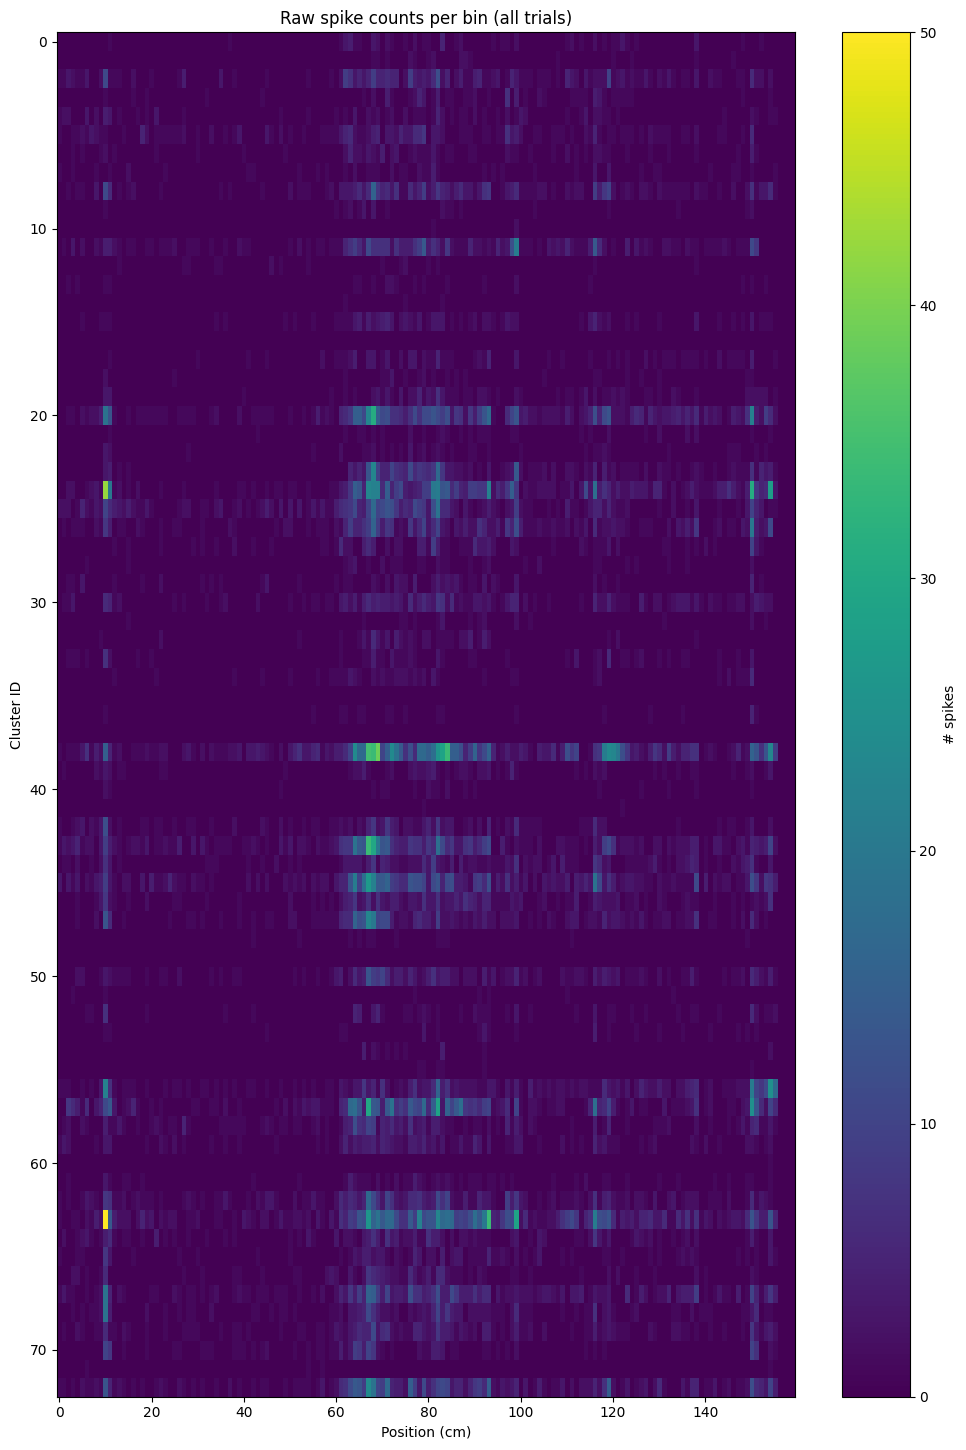

In [263]:
##### Rate map #####
# DONE Make a skeleton of the rate map that's [cells x nbins]
# DONE Generate an occupancy matrix: time spent per bin
# DONE Compute the total number of spikes for each cell per bin
# DONE Divide spikes/occupancy
# Convert to Hz.
# Smooth
# Sort by peak bin

clu_id_to_row = {row_id: i for i, row_id in enumerate(pp_idx)} # renumber clusters from 0 to n
n_clusters = len(pp_idx)
########################

n_bins = length_arm
bin_edges = np.arange(n_bins + 1)
occupancy_map = np.zeros(n_bins, dtype=float)
spike_counts = np.zeros((n_clusters, n_bins), dtype=float)
rate_map = np.zeros((n_clusters, n_bins), dtype=float)
all_bins = [] # used for sanity check

for start_frame, end_frame in trial_subset:
    # 1. OCCUPANCY
    pos = fixed_1d_pos[start_frame:end_frame] # positions visited during trial
    counts, _ = np.histogram(pos, bins=bin_edges) # position counts for each bin
    occupancy_map += counts / sampling_rate_whl # convert to seconds; sums to trial duration
    
    # 2. SPIKE COUNTS
    # convert trial times to res sr
    start_res = int(start_frame*sr_conversion)
    end_res = int(end_frame*sr_conversion)
    # select pp spikes for this trial
    mask = (res_pp >= start_res) & (res_pp <= end_res)
    # isolate relevant spikes and convert res timestamps to whl sr 
    spike_frames = (res_pp[mask]/sr_conversion).astype(int) 
    # assign each spike to a spatial bin
    spike_bins = np.floor(fixed_1d_pos[spike_frames]).astype(int)
    spike_bins = np.clip(spike_bins, 0, n_bins - 1) # filters out 160 and -1 values
    all_bins.extend(spike_bins) # append
    
    # iterate over clusters (rows) and bins and count spikes
    for cluster_id, bin_id in zip(clu_pp[mask], spike_bins):
        # iterate over each spike and return its corresponding spatial bin
        row = clu_id_to_row.get(cluster_id) # change to renumbered cluster id
        spike_counts[row][bin_id] += 1 # append spike to the correct clu_id and bin

# Sanity check: plot occupancy and spike counts
spk_per_bin = np.bincount(all_bins, minlength=n_bins)
fig, ax1 = plt.subplots(figsize=(10,3))
ax1.bar(np.arange(n_bins), occupancy_map, width=1, color='tab:blue', alpha=0.5)
ax1.set_ylabel('Seconds in bin', color='tab:blue'); ax1.tick_params(axis='y', labelcolor='tab:blue')
ax2 = ax1.twinx()
ax2.plot(spk_per_bin, color='tab:red')
ax2.set_ylabel('Spike count', color='tab:red'); ax2.tick_params(axis='y', labelcolor='tab:red')
ax1.set_xlabel('Position (cm)')
plt.title('Occupancy (bars) vs. total pp spikes (line)')
plt.tight_layout(); plt.show()

plt.figure(figsize=(10, n_clusters*0.2))
plt.imshow(spike_counts, aspect='auto', origin='upper',
           cmap='viridis', interpolation='nearest')
plt.colorbar(label='# spikes')
plt.xlabel('Position (cm)')
plt.ylabel('Cluster ID')
plt.title('Raw spike counts per bin (all trials)')
plt.tight_layout(); plt.show()

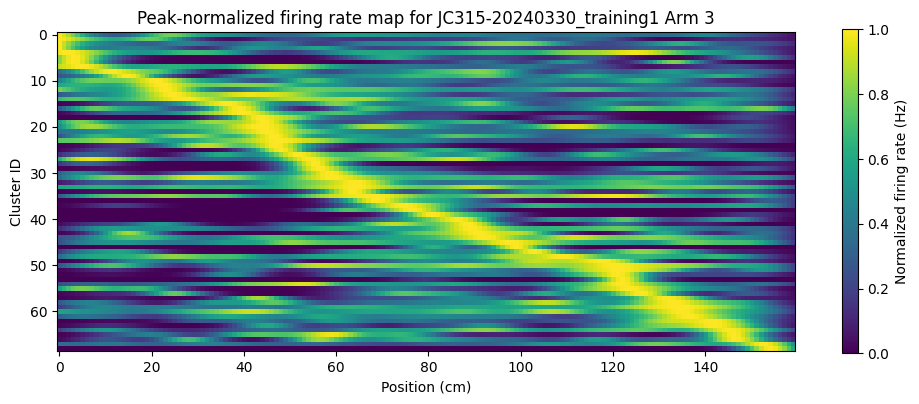

In [264]:
rate_map = np.zeros_like(spike_counts, dtype=float)
np.divide(spike_counts,
          occupancy_map,
          where=occupancy_map>0.01,
          out=rate_map)

rate_smoothed = gaussian_filter1d(rate_map, sigma=5, axis=1, mode='nearest')

max_fr = np.nanmax(rate_smoothed, axis=1, keepdims=True)
max_fr[max_fr == 0] = np.nan #ideally should filter out silent cells beforehand
rate_map_norm = rate_smoothed / max_fr

good_cells = ~np.all(np.isnan(rate_map_norm), axis=1)
rate_map_norm = rate_map_norm[good_cells]

peak_bin = np.nanargmax(rate_map_norm,axis=1)
sort_order = np.argsort(peak_bin)
rate_sorted = rate_map_norm[sort_order]

plt.figure(figsize=(10, n_clusters*0.3))
plt.imshow(rate_sorted, cmap='viridis', vmin=0, vmax=1, origin='upper')
plt.colorbar(label='Normalized firing rate (Hz)', shrink=0.15)
plt.xlabel('Position (cm)'); plt.ylabel('Cluster ID')
plt.title(f'Peak-normalized firing rate map for {animal}-{day}_{session} Arm {arm}')
plt.tight_layout(); plt.show()